## Fintech Project Work - Module 1: Segmenting clients
Cured by Matteo Bollettino, Madhurii Gatto, Lucia Gioria, Vittorio Nardi

The aim of this project is to analyse a dataset of bank clients in order to perform some clustering, to group them and extract the so called "Personas".

Personas are prototypes (not stereotypes!) used by banks to group people by their characteristics. This is done in order to make some customed financial advice, i.e. proposing to each individual a financial product that better suits his needs, but also for a lot of other useful applications.

In [1]:
#import tools and libraries
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns

Let's import the dataframe:

In [2]:
data = pd.read_excel(r'BankClients.xlsx')

In [3]:
# print summary statistics
print("\nSummary statistics\n", data.describe())


Summary statistics
                 ID          Age       Gender          Job         Area  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2500.500000    60.450400     0.528200     2.463400     1.385000   
std    1443.520003    21.822373     0.499254     1.250029     0.676215   
min       1.000000    19.000000     0.000000     1.000000     1.000000   
25%    1250.750000    42.000000     0.000000     2.000000     1.000000   
50%    2500.500000    61.000000     1.000000     2.000000     1.000000   
75%    3750.250000    80.000000     1.000000     2.000000     2.000000   
max    5000.000000    95.000000     1.000000     5.000000     3.000000   

          CitySize   FamilySize       Income       Wealth         Debt  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      1.926400     2.488400     0.575839     0.579228     0.429462   
std       0.763086     1.407644     0.212970     0.214550     0.223622   
min       1.0000

<AxesSubplot:>

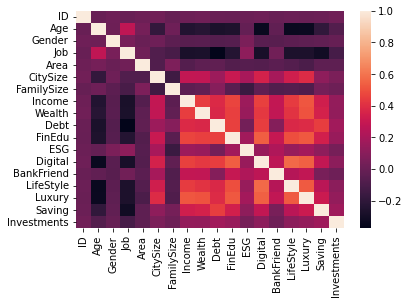

In [4]:
sns.heatmap(data.corr())

## Preprocessing

Let's put aside for one moment the categorical variables, in order to scale the numerical ones from 0 to 1.

Furthermore we discard the ID column, which is not useful for our analysis.

In [5]:
Xnum=data[['Age', 'FamilySize', 'Income', 'Wealth', 'Debt', 'FinEdu', 'ESG', 'Digital', 'BankFriend', 'LifeStyle', 'Luxury', 'Saving']]

In [6]:
print("\nFirst 5 rows\n", Xnum.describe())


First 5 rows
                Age   FamilySize       Income       Wealth         Debt  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     60.450400     2.488400     0.575839     0.579228     0.429462   
std      21.822373     1.407644     0.212970     0.214550     0.223622   
min      19.000000     1.000000     0.000000     0.000000     0.000000   
25%      42.000000     1.000000     0.414879     0.415849     0.255883   
50%      61.000000     2.000000     0.580220     0.588866     0.445857   
75%      80.000000     3.000000     0.749568     0.750469     0.598060   
max      95.000000     6.000000     0.983000     0.995597     0.976912   

            FinEdu          ESG      Digital   BankFriend    LifeStyle  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.511014     0.587227     0.527558     0.619068     0.462401   
std       0.186931     0.167703     0.213837     0.162662     0.221361   
min       0.000000    

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
Xnum_norm = min_max_scaler.fit_transform(Xnum) #scaling

In [8]:
X=pd.DataFrame(Xnum_norm, columns=['Age', 'FamilySize', 'Income', 'Wealth', 'Debt', 'FinEdu', 'ESG', 'Digital', 'BankFriend', 'LifeStyle', 'Luxury', 'Saving'])

Now let's put back the categorical variables via one hot encoding:

In [9]:
X['Gender1']=data['Gender'] #1=Female

In [10]:
label_encoder = LabelEncoder()
integer_encoded_job = label_encoder.fit_transform(data['Job'])
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_job = integer_encoded_job.reshape(len(integer_encoded_job), 1)
onehot_encoded_job = onehot_encoder.fit_transform(integer_encoded_job)

In [11]:
X['Job1']=onehot_encoded_job[:,0]
X['Job2']=onehot_encoded_job[:,1]
X['Job3']=onehot_encoded_job[:,2]
X['Job4']=onehot_encoded_job[:,3]
X['Job5']=onehot_encoded_job[:,4]

In [12]:
integer_encoded_area = label_encoder.fit_transform(data['Area'])
integer_encoded_area = integer_encoded_area.reshape(len(integer_encoded_area), 1)
onehot_encoded_area = onehot_encoder.fit_transform(integer_encoded_area)

In [13]:
X['Area1']=onehot_encoded_area[:,0]
X['Area2']=onehot_encoded_area[:,1]
X['Area3']=onehot_encoded_area[:,2]

In [14]:
integer_encoded_city = label_encoder.fit_transform(data['CitySize'])
integer_encoded_city = integer_encoded_city.reshape(len(integer_encoded_city), 1)
onehot_encoded_city = onehot_encoder.fit_transform(integer_encoded_city)

In [15]:
X['CitySize1']=onehot_encoded_city[:,0]
X['CitySize2']=onehot_encoded_city[:,1]
X['CitySize3']=onehot_encoded_city[:,2]

In [16]:
integer_encoded_inv = label_encoder.fit_transform(data['Investments'])
integer_encoded_inv = integer_encoded_inv.reshape(len(integer_encoded_inv), 1)
onehot_encoded_inv = onehot_encoder.fit_transform(integer_encoded_inv)

In [17]:
X['Investments1']=onehot_encoded_inv[:,0]
X['Investments2']=onehot_encoded_inv[:,1]
X['Investments3']=onehot_encoded_inv[:,2]

Preprocessed data:

In [18]:
X

,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,...,Job5,Area1,Area2,Area3,CitySize1,CitySize2,CitySize3,Investments1,Investments2,Investments3
0,0.065789,0.6,0.679599,0.705895,0.268264,0.770735,0.465122,0.718914,0.581720,0.612604,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.368421,0.0,0.873299,0.919090,0.747693,0.892883,0.521675,0.986877,0.778748,0.868977,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.250000,0.2,0.942846,0.902289,0.451701,0.504873,0.640388,0.772055,0.677446,0.761279,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.631579,0.4,0.548115,0.425051,0.614591,0.512343,0.518146,0.607305,0.648808,0.337033,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.184211,0.0,0.820609,0.734639,0.851100,0.889625,0.783674,0.730646,0.746853,0.915946,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.447368,0.2,0.900785,0.537026,0.788607,0.775233,0.763235,0.847560,0.493573,0.807758,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4996,0.934211,0.6,0.666716,0.272517,0.117191,0.437976,0.578984,0.627087,0.651062,0.390302,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4997,0.763158,0.0,0.710435,0.837072,0.299630,0.287988,0.867878,0.727196,0.663909,0.742585,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4998,0.855263,0.2,0.913810,0.831320,0.412595,0.678415,0.766699,0.818676,0.732115,0.536620,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


SPOILER ALERT: The following dataframe will be useful for the computation of the Kaiser-Meyer-Olkin value, in order to proceed with a Factor Analysis. This dataframe drops the last column of each one hot encoding, in order to avoid linearly correlated columns.

In [19]:
X2=X.drop(['Job5','Area3','CitySize3','Investments3'],1)

C:\Users\matte\AppData\Local\Temp/ipykernel_15688/2570753139.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X2=X.drop(['Job5','Area3','CitySize3','Investments3'],1)


## Factor Analysis

### Computation of the loadings matrix

We want to apply a strategy of dimensionality reduction but also to preserve interpretability: so, our natural choice is to apply Factor Analysis.


This method tries to find a reduced number of variables (factors), that are not directly observed, to explain the covariance structure of the original variables. In this way we group the existing variables by correlations between each other, with high correlation within a group and low correlation between groups. Each obtained group represents a measure of the factors responsible for the correlation, even if they were not directly observed.

We begin by calculating the Kaiser-Meyer-Olkin value, which represents how much data are suitable for a Factor Analysis and in particular represents the portion of common variance to be attributed to the potential factors.

In [20]:
# !pip install factor_analyzer
import factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

In [21]:
calculate_kmo(X2)

C:\Users\matte\anaconda3\lib\site-packages\factor_analyzer\utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


(array([0.88152856, 0.71169191, 0.93888236, 0.93479453, 0.89842359,
        0.93822492, 0.7687016 , 0.91342935, 0.77466217, 0.92259464,
        0.91946841, 0.86531902, 0.76593794, 0.36881291, 0.58140268,
        0.27343966, 0.18080736, 0.52610266, 0.52118552, 0.57031137,
        0.46301702, 0.6015712 , 0.53626422]),
 0.7575053480311369)

The value of 0.758 is perfectly sound, so we proceed with this technique.

In [22]:
fa = FactorAnalyzer(rotation=None)

In [23]:
fa.fit(X)

FactorAnalyzer(rotation=None, rotation_kwargs={})

In [24]:
total=np.sum(fa.get_eigenvalues()[0])
print(total)
fa.get_eigenvalues()[0]

26.9999999999999


array([ 5.39270071e+00,  2.23893624e+00,  1.81242145e+00,  1.62124167e+00,
        1.47907047e+00,  1.40776875e+00,  1.25962782e+00,  1.19937777e+00,
        1.11485806e+00,  1.02348724e+00,  9.83809593e-01,  9.20873787e-01,
        8.61732238e-01,  8.29929542e-01,  7.19920726e-01,  6.34272073e-01,
        5.94827213e-01,  5.56041509e-01,  5.48918564e-01,  4.99601737e-01,
        4.58964468e-01,  4.29940880e-01,  4.11677483e-01,  2.79483485e-14,
        3.67672887e-15, -1.51602809e-14, -2.98528191e-14])

In [25]:
np.cumsum(fa.get_eigenvalues()[0]/total) #cumulative explained variance

array([0.19972966, 0.28265322, 0.34977994, 0.40982593, 0.46460632,
       0.5167459 , 0.56339878, 0.60782018, 0.64911122, 0.68701816,
       0.72345555, 0.75756198, 0.78947799, 0.82021612, 0.84687985,
       0.87037141, 0.89240205, 0.91299618, 0.9333265 , 0.95183027,
       0.96882895, 0.98475269, 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [26]:
sum(fa.get_eigenvalues()[0]>=1.0)

10

Similarly to Pca, a way to select the number of factors is to consider the ones with associated eigenvalues greater than 1. 
So we initially choose to use 10 factors.

In [27]:
fa = FactorAnalyzer(n_factors=10,rotation=None)
fa.fit(X)

FactorAnalyzer(n_factors=10, rotation=None, rotation_kwargs={})

The loadings represent the correlation of each factor with each variable. By inspecting them we can give a real interpretation to the unobserved factors we are looking for.

In [28]:
loads=pd.DataFrame(fa.loadings_)
columns_names=np.array(list(X.columns))
loads.index=columns_names
loads

,0,1,2,3,4,5,6,7,8,9
Age,-0.425889,0.042454,-0.024937,-0.031760,-0.049054,-0.075676,-0.058616,0.026471,0.058257,0.154762
FamilySize,-0.037858,-0.248888,-0.041099,0.021445,0.070448,-0.033698,0.080224,-0.058355,-0.020858,0.090857
Income,0.633545,0.084193,0.079383,0.011785,0.013630,0.024695,0.057590,-0.043152,0.158148,0.053620
Wealth,0.614720,0.062778,0.096305,0.007562,0.021819,-0.010225,0.053972,-0.040963,0.141983,0.085199
Debt,0.625867,-0.217492,-0.017062,-0.010043,0.077309,-0.038918,0.047811,-0.049952,0.031302,-0.083928
FinEdu,0.691861,0.075736,0.076262,-0.009263,0.026350,-0.025988,-0.010461,-0.011601,0.183198,0.012855
ESG,0.192063,0.251815,0.055390,-0.028829,-0.082809,0.016593,-0.120668,0.091721,0.137329,-0.082476
Digital,0.702652,0.092255,0.096829,0.010347,0.051599,0.070152,0.023422,-0.002057,0.111560,-0.039305
BankFriend,0.285498,0.289139,0.127284,0.000632,-0.026304,-0.001576,-0.010695,-0.002308,0.307508,0.242424
LifeStyle,0.657839,0.114219,0.089803,0.013028,0.035950,0.084587,0.040367,0.003305,0.105347,-0.058355


In [29]:
relations=[]
for j in range(10):
    indexes=abs(fa.loadings_[:,j])>0.5
    relations.append(columns_names[indexes])

In [30]:
relations

[array(['Income', 'Wealth', 'Debt', 'FinEdu', 'Digital', 'LifeStyle',
        'Luxury', 'Job2', 'Job5', 'CitySize3'], dtype='<U12'),
 array(['Job2', 'Investments2'], dtype='<U12'),
 array(['Area1', 'Area2'], dtype='<U12'),
 array(['CitySize1', 'CitySize2'], dtype='<U12'),
 array(['Investments1', 'Investments3'], dtype='<U12'),
 array(['Investments1', 'Investments2'], dtype='<U12'),
 array(['Job1'], dtype='<U12'),
 array(['Area2', 'Area3'], dtype='<U12'),
 array([], dtype='<U12'),
 array([], dtype='<U12')]

Five factors seem sufficient since further ones just repeat some of the variables already correlated with the first five ones.

In [31]:
fa = FactorAnalyzer(n_factors=5,rotation=None)
fa.fit(X)

FactorAnalyzer(n_factors=5, rotation=None, rotation_kwargs={})

In [32]:
loads=pd.DataFrame(fa.loadings_)

loads.index=columns_names
loads

,0,1,2,3,4
Age,-0.427474,0.040422,-0.020662,-0.024052,0.026739
FamilySize,-0.037592,-0.270304,-0.040750,0.002816,-0.126172
Income,0.639147,0.093202,0.076556,0.031103,0.006313
Wealth,0.620022,0.068681,0.094022,0.030352,-0.016236
Debt,0.634826,-0.231041,-0.020785,-0.015884,-0.118355
FinEdu,0.697423,0.088816,0.074368,0.019102,-0.011683
ESG,0.193161,0.276338,0.054809,-0.001031,0.147690
Digital,0.711058,0.110494,0.096361,0.027609,-0.002771
BankFriend,0.282857,0.293757,0.121519,0.041556,0.064014
LifeStyle,0.665501,0.133934,0.089048,0.028441,0.019506


In [33]:
relations=[]
for j in range(5):
    indexes=abs(fa.loadings_[:,j])>0.5
    relations.append(columns_names[indexes])

In [34]:
relations

[array(['Income', 'Wealth', 'Debt', 'FinEdu', 'Digital', 'LifeStyle',
        'Luxury', 'Saving', 'Job2', 'Job5'], dtype='<U12'),
 array(['Job2', 'Investments3'], dtype='<U12'),
 array(['Area1', 'Area2'], dtype='<U12'),
 array(['CitySize1', 'CitySize2'], dtype='<U12'),
 array(['Investments3'], dtype='<U12')]

### Interpretation of the factors
- Factor 1 is positively correlated with Financial Aspects and with whether the subject still works (positive with worker and negative with retired).

- Factor 2 is related to the type of Job and the type of Investments (negative with worker, negative with capital accumulation   investments, positive with lump sum investments).

- Factor 3 is related to Area of Living (positive with Central/South area, negative with North area).

- Factor 4 is related to the Dimension of the City (positive with medium sized, negative with small sized).

- Factor 5 is related to Investments (positive with capital accumulation investments, negative with no investments and lump sum investments).

In [35]:
X_factor=fa.transform(X) #let's obtain the dataset in the factors coordinates

In [36]:
df_factor=pd.DataFrame(X_factor, columns=['Financial','Job','Area','City Dimension','Investments'])
df_factor.head()

,Financial,Job,Area,City Dimension,Investments
0,0.074219,0.813477,1.999023,1.539673,0.477539
1,1.968506,-0.085938,1.950684,-0.125488,1.420898
2,1.145264,-0.276367,-0.592773,1.145020,0.358398
3,0.140625,-0.122070,-0.525391,0.955750,-1.383789
4,1.591309,1.190430,0.233887,-0.395813,-0.605469


In [37]:
factor_means=np.mean(df_factor,axis=0)
factor_means

Financial        -0.000678
Job               0.001096
Area              0.000248
City Dimension    0.000563
Investments       0.002055
dtype: float64

The mean of each factor is basically zero, so we can conveniently use the factor means to analyse the composition of each cluster.

In [38]:
random_state = 42 #seed for reproducibility

## K-Means

As a first step, we exploit the classical K-Means as our clustering method, let's look for the optimal number of clusters.

### Knee - Elbow Analysis 

In [39]:
def KneeElbowAnalysis(x,max_k=12):
    k_values = range(1,max_k)
    clusterings = [KMeans(n_clusters=k, random_state=random_state).fit(x) for k in k_values]
    centroids = [clustering.cluster_centers_ for clustering in clusterings]

    D_k = [cdist(x, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/x.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]

    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss

    kIdx = 10-1
    
    #
    # elbow curve
    #
    fig = plt.figure()
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.xticks(k_values)
    plt.plot(k_values, wcss, 'o-', color='red', label='WCSS')
    plt.plot(k_values, bss, 'o-', color='blue', label='BCSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.title('KMeans Clustering');


We look for an elbow in the following curve to select the number of clusters to use.

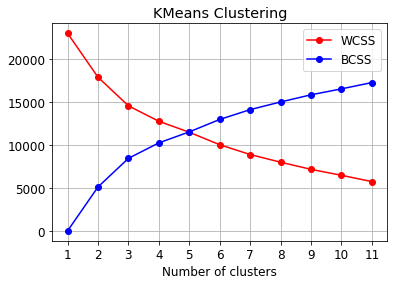

In [40]:
KneeElbowAnalysis(df_factor)

### Silhouettes

We also look at the silhouette measure for different number of clusters.

For n_clusters = 2 The average silhouette_score is : 0.12694550408235422
For n_clusters = 3 The average silhouette_score is : 0.17167614098034006
For n_clusters = 4 The average silhouette_score is : 0.17024099334282855
For n_clusters = 5 The average silhouette_score is : 0.1554735744264115
For n_clusters = 6 The average silhouette_score is : 0.15491720706814407
For n_clusters = 7 The average silhouette_score is : 0.15350917333104888
For n_clusters = 8 The average silhouette_score is : 0.17545782494220716
For n_clusters = 9 The average silhouette_score is : 0.18930930866107087


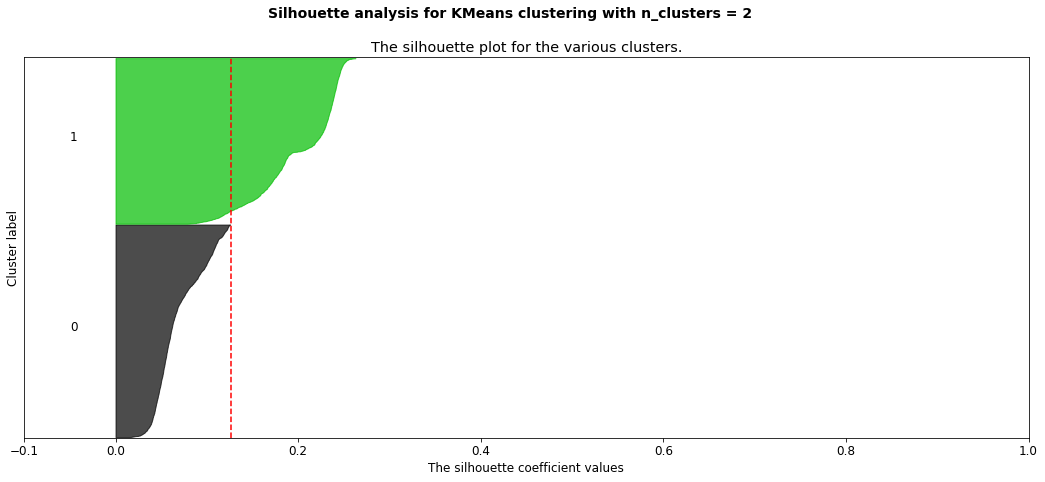

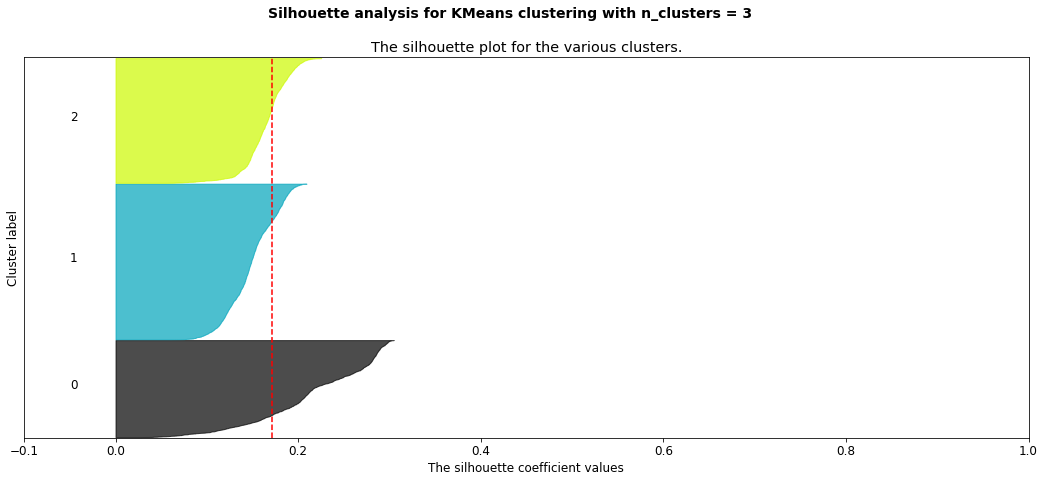

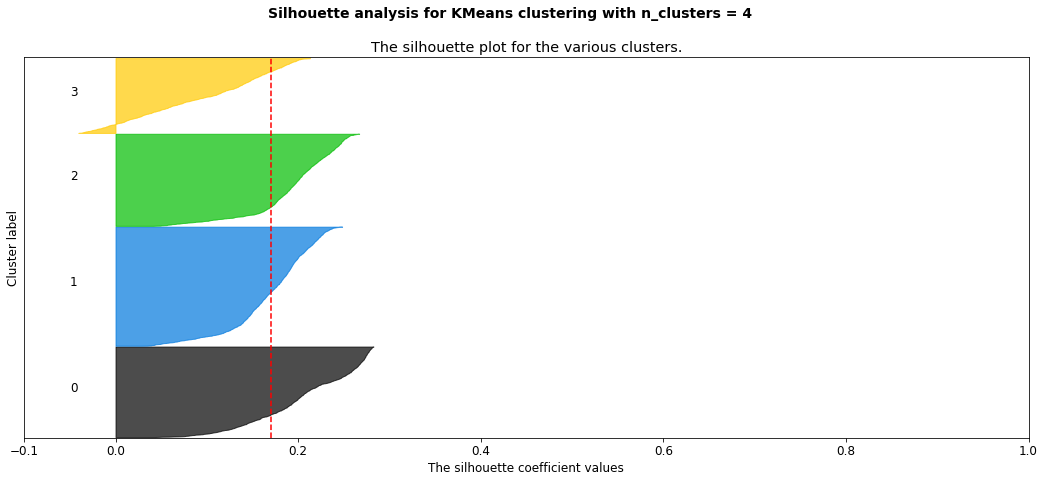

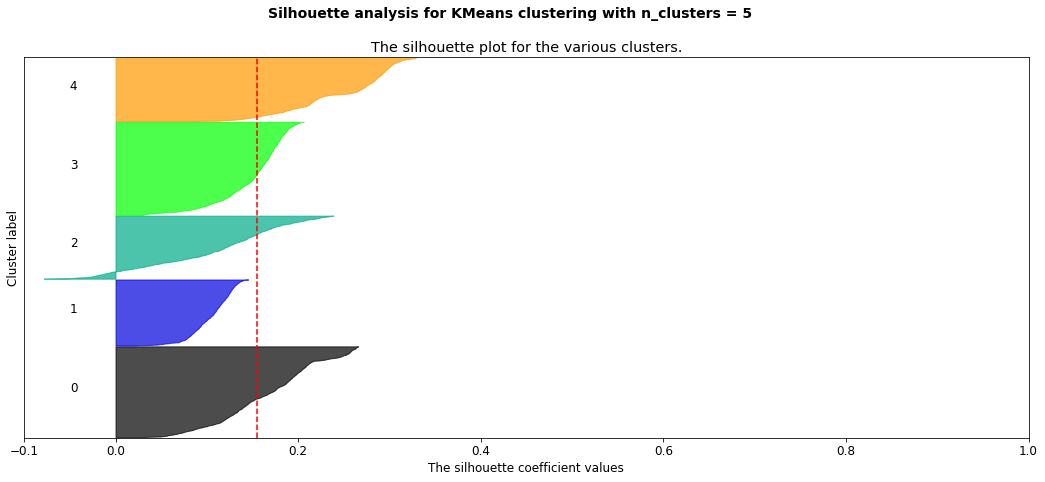

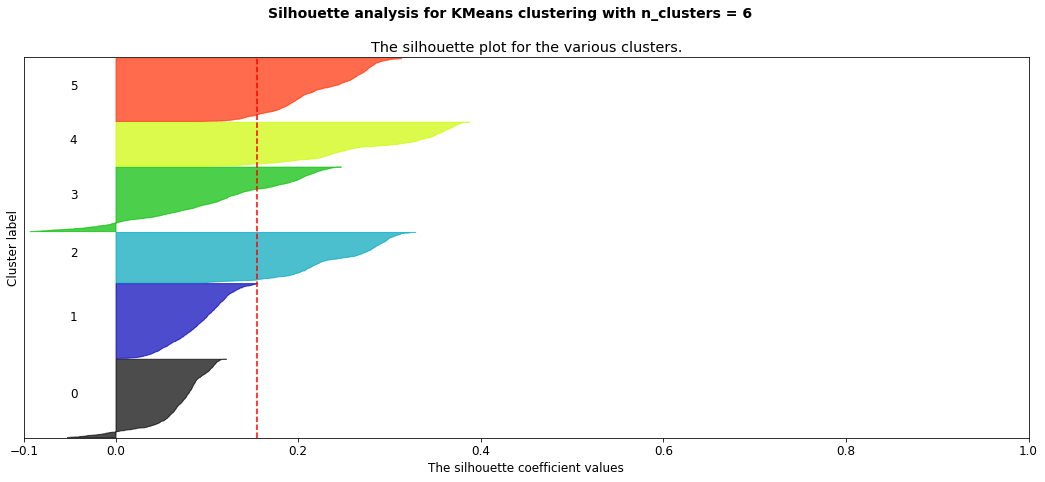

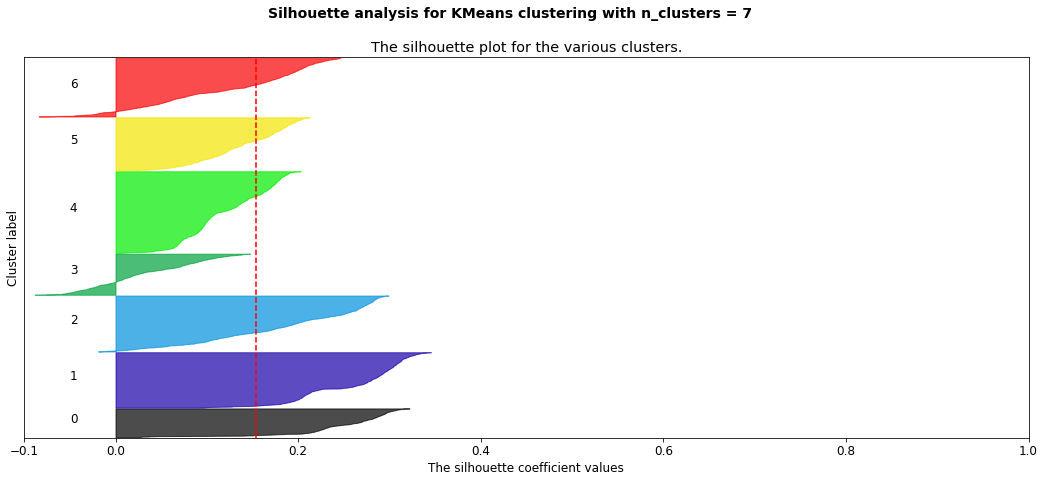

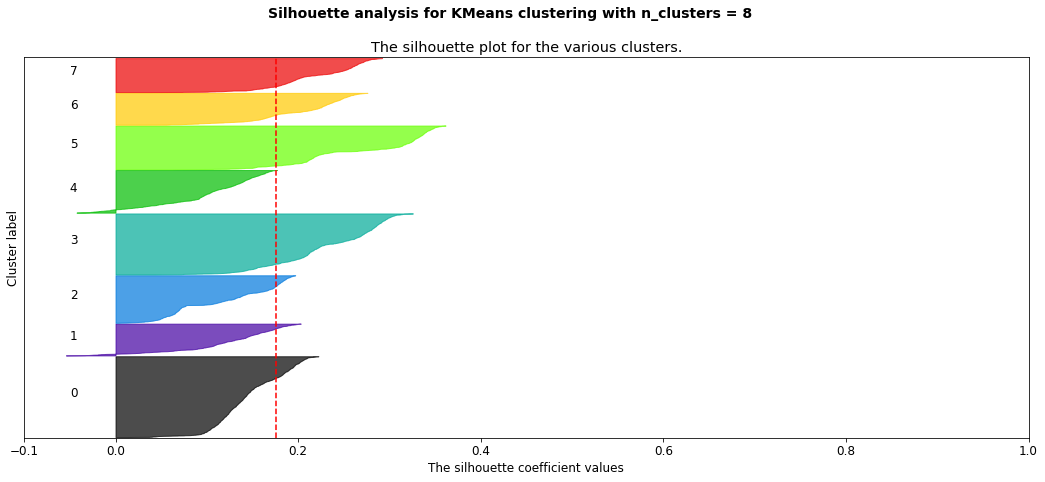

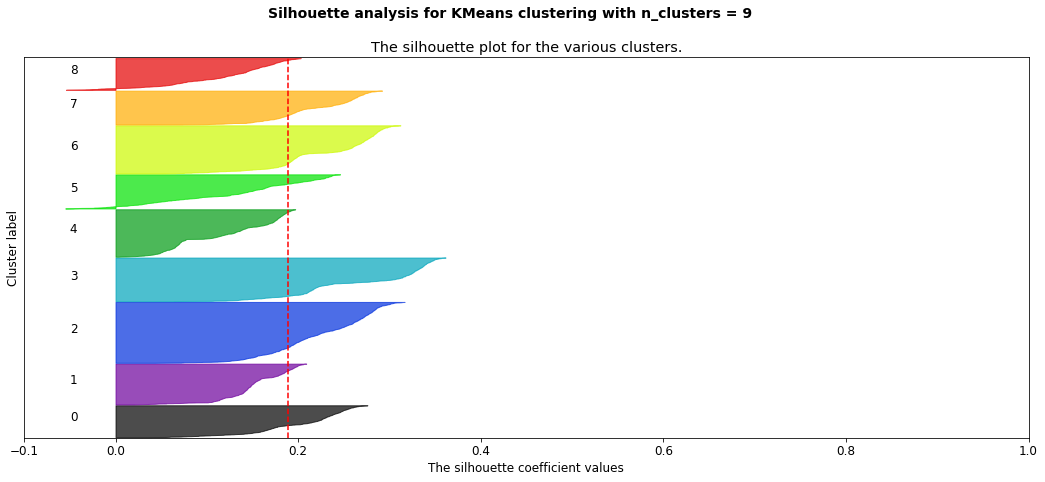

In [41]:
range_n_clusters = range(2,10)

for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The average silhouette for K=3 is a local maximum, equal to 0.1717, so we choose to work with 3 clusters.
This choice is also confirmed by the slight elbow in the Knee-Elbow Analysis.

In [42]:
clusterer = KMeans(n_clusters=3, random_state=random_state)
cluster_labels = clusterer.fit_predict(X_factor)

In [43]:
np.unique(clusterer.labels_,return_counts=True)

(array([0, 1, 2]), array([1790, 1742, 1468], dtype=int64))

In [44]:
cluster1=X_factor[clusterer.labels_==0,:]
cluster2=X_factor[clusterer.labels_==1,:]
cluster3=X_factor[clusterer.labels_==2,:]

In [45]:
np.mean(cluster1,axis=0)-factor_means

Financial         0.487353
Job              -0.699487
Area             -0.318094
City Dimension   -0.036490
Investments       0.534724
dtype: float64

In [46]:
np.mean(X[clusterer.labels_==0])-np.mean(X)

Age            -0.059308
FamilySize      0.018968
Income          0.042930
Wealth          0.042029
Debt            0.080450
FinEdu          0.046700
ESG             0.003299
Digital         0.050181
BankFriend     -0.013941
LifeStyle       0.046481
Luxury          0.045089
Saving          0.058993
Gender1        -0.006971
Job1           -0.120683
Job2            0.268340
Job3            0.020362
Job4            0.001505
Job5           -0.169524
Area1           0.030666
Area2          -0.028846
Area3          -0.001820
CitySize1      -0.018868
CitySize2      -0.013517
CitySize3       0.032385
Investments1   -0.262800
Investments2   -0.299200
Investments3    0.562000
dtype: float64

Low score in factor 2 -> They are workers, confirmed by the above average value of Job2.

Quite High score in factor 5 -> They prefer capital accumulation investments, confirmed by the above average value of Investments3.

Quite High score in factor 1 -> Interested in financial aspects, higher income and financial education.

Furthemore they are younger than average.

In [47]:
np.mean(cluster2,axis=0)-factor_means

Financial         0.323475
Job              -0.039257
Area              0.186548
City Dimension   -0.063538
Investments      -1.225466
dtype: float64

In [48]:
np.mean(X[clusterer.labels_==1])-np.mean(X)

Age            -0.050801
FamilySize      0.015523
Income          0.036733
Wealth          0.039043
Debt            0.068899
FinEdu          0.041266
ESG            -0.006513
Digital         0.047283
BankFriend     -0.003777
LifeStyle       0.040487
Luxury          0.044291
Saving          0.047514
Gender1        -0.017293
Job1           -0.121800
Job2            0.277758
Job3            0.003347
Job4            0.011895
Job5           -0.171200
Area1           0.000977
Area2          -0.019939
Area3           0.018962
CitySize1      -0.018889
CitySize2      -0.026062
CitySize3       0.044952
Investments1    0.225145
Investments2    0.212855
Investments3   -0.438000
dtype: float64

Low score in factor 5 -> They prefer lump sum investments (but also no investments at all).

Furthermore they are mostly workers, they are younger than average and have slightly above average financial aspects.

In [49]:
np.mean(cluster3,axis=0)-factor_means

Financial        -0.978104
Job               0.899501
Area              0.166500
City Dimension    0.119891
Investments       0.802184
dtype: float64

In [50]:
np.mean(X[clusterer.labels_==2])-np.mean(X)

Age             0.132599
FamilySize     -0.041549
Income         -0.095936
Wealth         -0.097579
Debt           -0.179854
FinEdu         -0.105912
ESG             0.003706
Digital        -0.117296
BankFriend      0.021481
LifeStyle      -0.104721
Luxury         -0.107536
Saving         -0.128315
Gender1         0.029021
Job1            0.291688
Job2           -0.656800
Job3           -0.028800
Job4           -0.015950
Job5            0.409863
Area1          -0.038551
Area2           0.058833
Area3          -0.020282
CitySize1       0.045422
CitySize2       0.047409
CitySize3      -0.092831
Investments1    0.053276
Investments2    0.112244
Investments3   -0.165520
dtype: float64

Low score in factor 1 -> They are not interested in financial aspects.

High score in factor 2 -> They don't have a job, infact they are either unemployed or retired.

High score in factor 5 -> They should prefer capital accumulation investments but by looking at the investments features values we mostly see no or lump sum investments.

Furthermore they have below average financial aspects, they are older than average, they mostly live in the central area, in small and medium sized cities.

### Projections of clusters in the factors space

Factors 1,2 and 5 seem the most important for discrimination, so let's plot the clusters in the 3D space defined by these factors, also with the three 2D projections:

Text(0.5, 0, 'Factor 5')

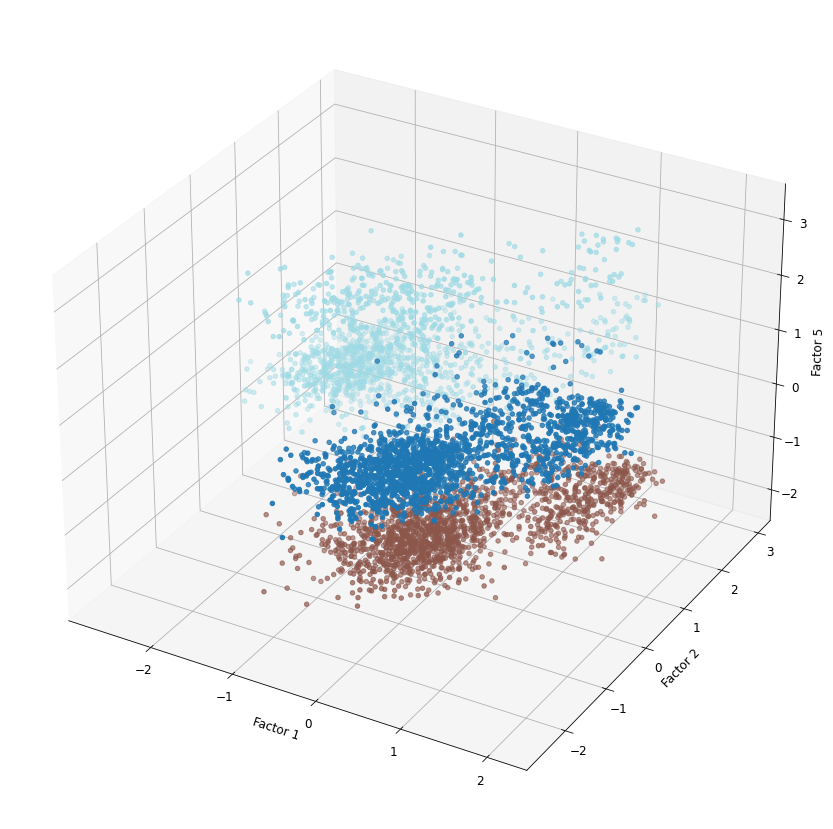

In [51]:
fig=plt.figure(figsize=(15,15))
ax=plt.axes(projection='3d')
ax.scatter3D(X_factor[:,0],X_factor[:,1],X_factor[:,4],c=clusterer.labels_,cmap=plt.get_cmap('tab20'))
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 5')

Text(0, 0.5, 'Factor 2')

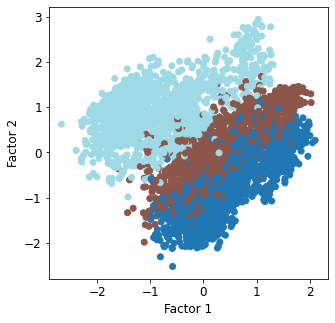

In [52]:
fig=plt.figure(figsize=(5,5))
ax=plt.axes()
ax.scatter(X_factor[:,0],X_factor[:,1],c=clusterer.labels_,cmap=plt.get_cmap('tab20'))
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')

Text(0, 0.5, 'Factor 5')

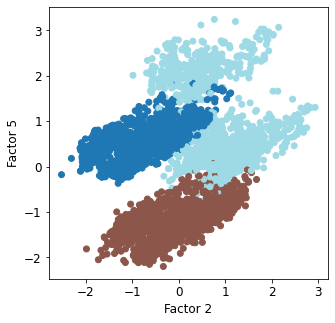

In [53]:
fig=plt.figure(figsize=(5,5))
ax=plt.axes()
ax.scatter(X_factor[:,1],X_factor[:,4],c=clusterer.labels_,cmap=plt.get_cmap('tab20'))
ax.set_xlabel('Factor 2')
ax.set_ylabel('Factor 5')

Text(0, 0.5, 'Factor 5')

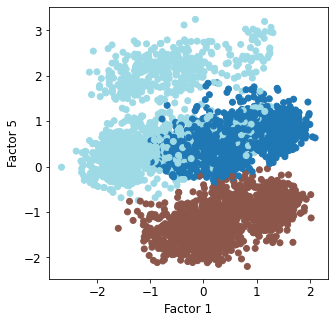

In [54]:
fig=plt.figure(figsize=(5,5))
ax=plt.axes()
ax.scatter(X_factor[:,0],X_factor[:,4],c=clusterer.labels_,cmap=plt.get_cmap('tab20'))
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 5')

## Hierarchical Clustering

With K-Means we obtain a good segmentation. But can we do better?

We notice from the 2D projections that some clusters may be further separated. Also from a financial point of view we may want a more specific division of the clients.
Hence, let's try a different method, Hierarchical clustering, which gives us more insight on the number of clusters we should use.

Furthermore, in the following analysis, we will use only the three most significant factors as coordinates.

### Dendrogram

In [55]:
columns=[0,1,4]
X_factor_reduced=X_factor[:,columns]
X_factor_reduced

array([[ 0.07421875,  0.81347656,  0.47753906],
       [ 1.96850586, -0.0859375 ,  1.42089844],
       [ 1.14526367, -0.27636719,  0.35839844],
       ...,
       [ 0.70703125,  0.33300781,  1.04199219],
       [ 1.16088867, -0.09667969,  0.51464844],
       [ 0.67602539, -0.26660156,  0.31738281]])

In [56]:
z = linkage(X_factor_reduced, 'ward')

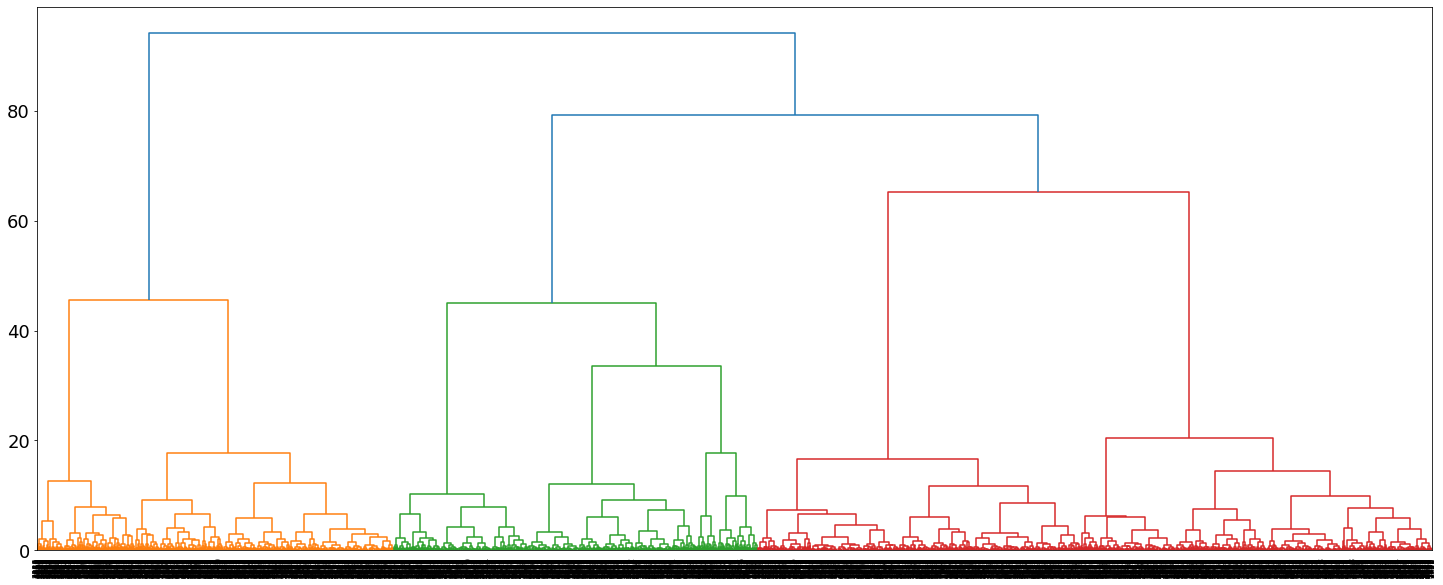

In [57]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
dendrogram(z, 
    #leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

### Knee - Elbow Analysis

In [58]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(z, k, criterion='maxclust')
    centroids = [np.mean(X_factor_reduced[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(X_factor_reduced, centroids, 'euclidean')
    D = cdist(X_factor_reduced, centroids, 'euclidean')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)

    avgWithinSS = sum(d)/X_factor_reduced.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(X_factor_reduced)**2)/X_factor_reduced.shape[0]
    
    bss = tss-wss
    
    wss_values += [wss]
    bss_values += [bss]

We look again for an elbow to select the number of clusters.

C:\Users\matte\AppData\Local\Temp/ipykernel_11784/1324989459.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
C:\Users\matte\AppData\Local\Temp/ipykernel_11784/1324989459.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')


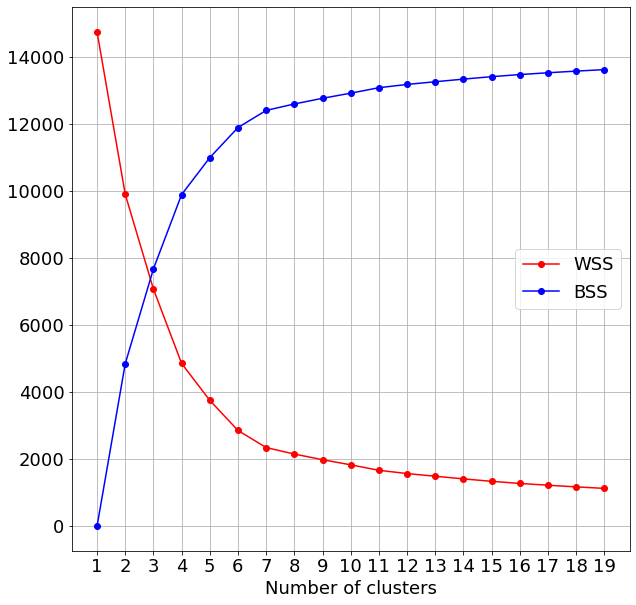

In [59]:
fig = plt.figure(figsize=(10, 10))
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.xticks(k_values)
plt.legend()
plt.savefig('kneeelbow_factor.png')

Let's inspect the division in 6 clusters, which seems a good idea from the graph and also from the dendrogram.

### Projections of clusters in the factors space

In [60]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_factor_reduced)

array([2, 0, 0, ..., 0, 0, 0], dtype=int64)

In [61]:
np.unique(cluster.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([ 825, 1260,  927, 1157,  352,  479], dtype=int64))

Text(0.5, 0, 'Factor 5')

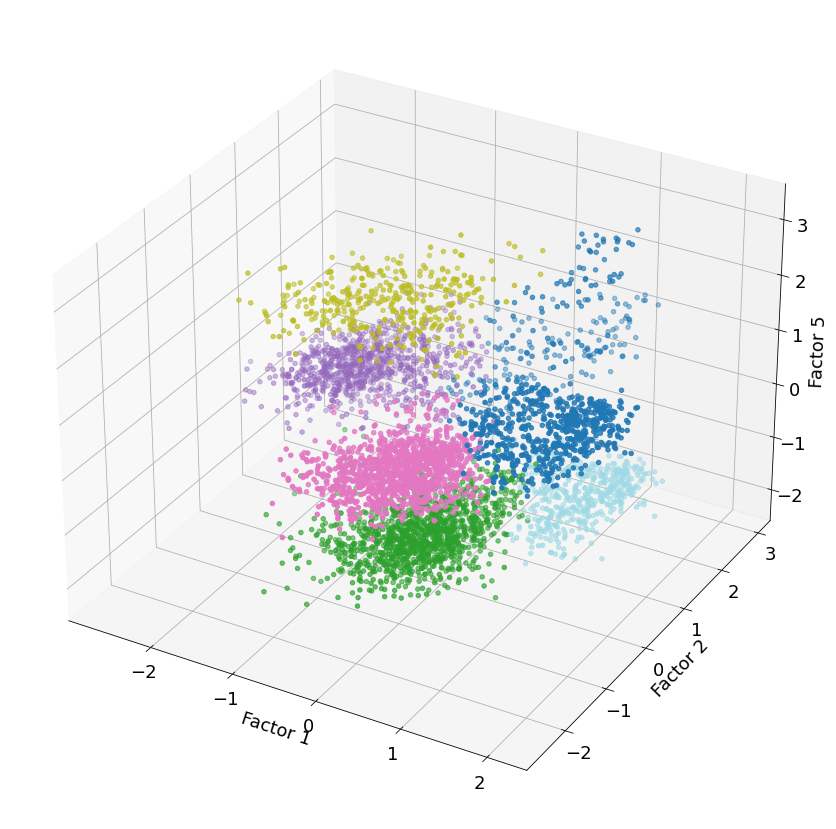

In [62]:
fig = plt.figure(figsize=(15,15))
ax=plt.axes(projection='3d')
ax.scatter3D(X_factor_reduced[:,0],X_factor_reduced[:,1],X_factor_reduced[:,2],c=cluster.labels_, cmap=plt.get_cmap('tab20'))
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 5')

Text(0, 0.5, 'Factor 2')

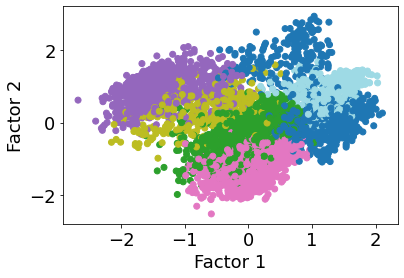

In [63]:
plt.scatter(X_factor_reduced[:, 0], X_factor_reduced[:, 1], c=cluster.labels_,cmap=plt.get_cmap('tab20'))
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')

Text(0, 0.5, 'Factor 5')

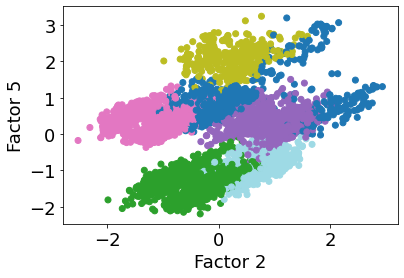

In [64]:
plt.scatter(X_factor_reduced[:, 1], X_factor_reduced[:, 2], c=cluster.labels_,cmap=plt.get_cmap('tab20'))
plt.xlabel('Factor 2')
plt.ylabel('Factor 5')

Text(0, 0.5, 'Factor 5')

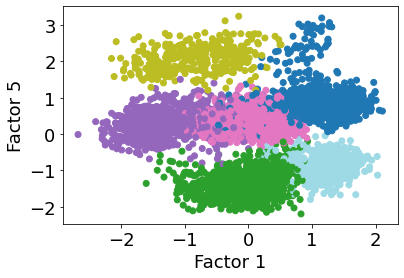

In [65]:
plt.scatter(X_factor_reduced[:, 0], X_factor_reduced[:, 2], c=cluster.labels_,cmap=plt.get_cmap('tab20'))
plt.xlabel('Factor 1')
plt.ylabel('Factor 5')

Nice! Let's go on with the interpretation of each cluster, as before.

In [66]:
factor_means=np.mean(X_factor_reduced,axis=0)
factor_means  #still zero mean, which is convenient

array([-0.00067832,  0.00109648,  0.00205488])

In [67]:
cluster1=pd.DataFrame(X_factor_reduced[cluster.labels_==0,:],columns=['Financial','Job','Investments'])
cluster2=pd.DataFrame(X_factor_reduced[cluster.labels_==1,:],columns=['Financial','Job','Investments'])
cluster3=pd.DataFrame(X_factor_reduced[cluster.labels_==2,:],columns=['Financial','Job','Investments'])
cluster4=pd.DataFrame(X_factor_reduced[cluster.labels_==3,:],columns=['Financial','Job','Investments'])
cluster5=pd.DataFrame(X_factor_reduced[cluster.labels_==4,:],columns=['Financial','Job','Investments'])
cluster6=pd.DataFrame(X_factor_reduced[cluster.labels_==5,:],columns=['Financial','Job','Investments'])

## Conclusions

### Interpretation of the obtained clusters


Little recap on factors interpretation:

- Factor 1 is positively correlated with Financial Aspects and with whether the subject still works (positive with worker and negative with retired).

- Factor 2 is related to the type of Job and the type of investments (negative with worker, negative with capital accumulation investments, positive with lump sum investments).

- Factor 5 is related to Investments (positive with capital accumulation investments, negative with no investments and lump sum investments).

In [68]:
np.mean(cluster1,axis=0)-factor_means

Financial      1.077699
Job            0.476774
Investments    0.918314
dtype: float64

In [69]:
np.mean(X[cluster.labels_==0])-np.mean(X)

Age            -0.143343
FamilySize     -0.103498
Income          0.176111
Wealth          0.163329
Debt            0.118851
FinEdu          0.175302
ESG             0.086977
Digital         0.222279
BankFriend      0.106968
LifeStyle       0.215334
Luxury          0.248709
Saving          0.070818
Gender1        -0.014261
Job1            0.045473
Job2           -0.011952
Job3            0.053624
Job4            0.012539
Job5           -0.099685
Area1           0.148739
Area2          -0.070055
Area3          -0.078685
CitySize1      -0.280903
CitySize2      -0.137248
CitySize3       0.418152
Investments1   -0.176739
Investments2   -0.210715
Investments3    0.387455
dtype: float64

####  Profile 1: The Young City Caiman
High score in factor 1 -> they have a high financial interest, they are mostly executives and entrepreneurs

High score in factor 5 -> They invest in capital accumulation

Furthermore, they live in a big city in the North and are younger than average.

In [70]:
np.mean(cluster2,axis=0)-factor_means

Financial     -0.037345
Job           -0.374804
Investments   -1.366411
dtype: float64

In [71]:
np.mean(X[cluster.labels_==1])-np.mean(X)

Age            -0.008715
FamilySize      0.063590
Income         -0.028773
Wealth         -0.022370
Debt            0.045162
FinEdu         -0.027265
ESG            -0.052155
Digital        -0.032198
BankFriend     -0.061009
LifeStyle      -0.031354
Luxury         -0.050405
Saving          0.033918
Gender1        -0.009946
Job1           -0.121800
Job2            0.295581
Job3           -0.009752
Job4            0.006378
Job5           -0.170406
Area1          -0.040279
Area2          -0.005870
Area3           0.046149
CitySize1       0.083686
CitySize2       0.037600
CitySize3      -0.121286
Investments1    0.318946
Investments2    0.119054
Investments3   -0.438000
dtype: float64

#### Profile 2: The Southern Village Worker 
Low score in factor 5 -> They do not invest or invest lump sums.

Quite low score in factor 2 -> They are workers.

Furthermore, they have slightly below average financial aspects and they live in small or medium sized cities in the South area.

In [74]:
np.mean(cluster3,axis=0)-factor_means

Financial     -1.357221
Job            0.926903
Investments    0.246448
dtype: float64

In [75]:
np.mean(X[cluster.labels_==2])-np.mean(X)

Age             0.199107
FamilySize     -0.061003
Income         -0.165781
Wealth         -0.156898
Debt           -0.263326
FinEdu         -0.163502
ESG             0.017284
Digital        -0.190741
BankFriend      0.007015
LifeStyle      -0.173603
Luxury         -0.191334
Saving         -0.182438
Gender1         0.066191
Job1            0.196431
Job2           -0.656800
Job3           -0.028800
Job4           -0.011691
Job5            0.500860
Area1          -0.080108
Area2           0.095378
Area3          -0.015270
CitySize1       0.090112
CitySize2       0.071958
CitySize3      -0.162070
Investments1    0.161148
Investments2    0.276852
Investments3   -0.438000
dtype: float64

#### Profile 3: The Old Slacker 

Low score in factor 1 -> they are not interested in financial aspects.

High score in factor 2 -> they are either unemployed or retired.

Furthermore, they are older than average, they do not invest or invest lump sums, they live in small or medium sized cities in the Central area.

In [76]:
np.mean(cluster4,axis=0)-factor_means

Financial      0.079192
Job           -1.109612
Investments    0.359262
dtype: float64

In [77]:
np.mean(X[cluster.labels_==3])-np.mean(X)

Age            -0.019755
FamilySize      0.092294
Income         -0.026122
Wealth         -0.023714
Debt            0.051974
FinEdu         -0.026309
ESG            -0.059474
Digital        -0.039566
BankFriend     -0.074004
LifeStyle      -0.042352
Luxury         -0.061032
Saving          0.041908
Gender1        -0.013075
Job1           -0.121800
Job2            0.314678
Job3           -0.011514
Job4           -0.010164
Job5           -0.171200
Area1          -0.023385
Area2          -0.013347
Area3           0.036732
CitySize1       0.130938
CitySize2       0.062103
CitySize3      -0.193041
Investments1   -0.262800
Investments2   -0.299200
Investments3    0.562000
dtype: float64

#### Profile 4: "Average Joe", the Accumulator

Low score in factor 2 -> they are workers and they prefer capital accumulation investments (confirmed by the positive value of factor 5 and by the above average value of Investments3).

Furthermore, they are spread on all the territory and have slightly below average financial aspects.

In [78]:
np.mean(cluster5,axis=0)-factor_means

Financial     -0.808876
Job            0.288673
Investments    2.078306
dtype: float64

In [79]:
np.mean(X[cluster.labels_==4])-np.mean(X)

Age             0.120943
FamilySize      0.018229
Income         -0.072648
Wealth         -0.082758
Debt           -0.100293
FinEdu         -0.099985
ESG            -0.018773
Digital        -0.121138
BankFriend     -0.009803
LifeStyle      -0.107377
Luxury         -0.097227
Saving         -0.057495
Gender1         0.000209
Job1            0.375359
Job2           -0.656800
Job3           -0.028800
Job4           -0.010036
Job5            0.320277
Area1          -0.068950
Area2           0.059832
Area3           0.009118
CitySize1       0.084173
CitySize2       0.050668
CitySize3      -0.134841
Investments1   -0.262800
Investments2   -0.299200
Investments3    0.562000
dtype: float64

#### Profile 5: The Unconventional Elderly

High score in factor 5 -> They invest in capital accumulation.

Low score in factor 1 -> They are not interested in financial aspects.

Furthermore they are either unemployed or retired, they are older than average, they live in medium and small sized cities in the Central area.

In [80]:
np.mean(cluster6,axis=0)-factor_means

Financial      1.271808
Job            0.839004
Investments   -0.859330
dtype: float64

In [81]:
np.mean(X[cluster.labels_==5])-np.mean(X)

Age            -0.156679
FamilySize     -0.107283
Income          0.209681
Wealth          0.199275
Debt            0.134270
FinEdu          0.223237
ESG             0.111391
Digital         0.255583
BankFriend      0.148628
LifeStyle       0.228776
Luxury          0.293382
Saving          0.082900
Gender1        -0.045945
Job1           -0.119712
Job2            0.236728
Job3            0.038006
Job4            0.016178
Job5           -0.171200
Area1           0.111961
Area2          -0.060216
Area3          -0.051745
CitySize1      -0.288846
CitySize2      -0.189018
CitySize3       0.477864
Investments1   -0.018541
Investments2    0.456541
Investments3   -0.438000
dtype: float64

####  Profile 6: Daddy's Boy
High score in factor 1 -> They have a high financial interest and they have a job, mostly workers but also other positions.

Low score in factor 5 -> They invest lump sums. 

Furthermore, they live in a big city in the North and are younger than average.

To sum up, with our client segmentation we obtained six personas:

- The conventional metropolis youngsters
- The workers
- The conventional unemployed/retired elderly
- The accumulators
- The unconventional unemployed/retired elderly
- The unconventional metropolis youngsters